In [1]:
# Some setting up stuff. This cell is hidden from the Sphinx-rendered documentation.
%matplotlib inline
%config InlineBackend.figure_format = 'png'
np.random.seed(42)

# Maximum likelihood: Gaussian process hyperparameters

**NOTE:** *Maximum likelihood estimation is very experimental in BayesPy. The whole messaging system is being rewritten in order to support much better MLE along with non-conjugate distributions and a bunch of other useful features. This example just shows how to do MLE currently if you need to but it doesn't work very well (the optimizer is bad).*

Create some 3-dimensional inputs:

In [2]:
import numpy as np
N = 200
X = np.random.randn(N, 1)

Pre-compute a squared distance matrix for the inputs:

In [3]:
from scipy.spatial import distance
D = distance.squareform(distance.pdist(X, 'sqeuclidean'))

Define a covariance function (exponentiated square or squared exponential):

In [4]:
def exponentiated_square(parameters):
    lengthscale = np.exp(parameters[0])
    magnitude = np.exp(parameters[1])
    return magnitude**2 * np.exp(-D/lengthscale) + 1e-6 * np.identity(N)

Implement the backward gradient pass for the exponentiated square:

In [5]:
def d_parameters(d_exponentiated_square, parameters):
    """ Backward gradient of exponentiated square w.r.t. the parameters """
    lengthscale = np.exp(parameters[0])
    magnitude = np.exp(parameters[1])
    K = magnitude**2 * np.exp(-D/lengthscale)
    return [
        np.sum(d_exponentiated_square * K * D / lengthscale),
        np.sum(d_exponentiated_square * K * 2)
    ]

BayesPy uses precision matrix instead of covariance matrix for the Gaussian variables, thus we need to implement the matrix inversion and its gradient:

In [6]:
def inverse(K):
    return np.linalg.inv(K)


def d_covariance(d_inverse, K):
    """ Backward gradient of inverse w.r.t. the covariance matrix """
    invK = np.linalg.inv(K)
    return -np.dot(invK, np.dot(d_inverse, invK))

Create a maximum likelihood node for the covariance hyperparameters. Because the maximum likelihood estimation assumes unbounded variables, the node represents the parameters in log-scale:

In [7]:
import bayespy as bp
parameters = bp.nodes.MaximumLikelihood(np.log([1, 1]))

Create nodes that use our defined functions to compute the precision matrix from the parameters. `Function` takes the actual function as the first argument and then a 2-tuple for each input argument of the function. The first tuple elements are the input nodes and the second tuple elements are the corresponding gradient pass functions:

In [8]:
Covariance = bp.nodes.Function(
    exponentiated_square,
    (parameters, d_parameters)
)
Lambda = bp.nodes.Function(
    inverse,
    (Covariance, d_covariance)
)

Create a noiseless latent Gaussian process node::

In [9]:
latent = bp.nodes.Gaussian(np.zeros(N), Lambda)

Observation noise precision:

In [10]:
tau = bp.nodes.Gamma(1e-3, 1e-3)

Node for the observations:

In [11]:
Y = bp.nodes.GaussianARD(latent, tau)

Draw a sample from our model and use it as a data:

In [12]:
K = exponentiated_square(np.log([0.3, 5]))
data = bp.nodes.Gaussian(np.zeros(N), np.linalg.inv(K + 0.1**2*np.identity(N))).random()
Y.observe(data)

Construct inference engine:

In [13]:
Q = bp.inference.VB(Y, latent, tau, parameters)

Use gradient based optimization to learn the parameters. We collapse `latent` and `tau` so that the learning is more efficient because the coupling between `latent` and `parameters` is quite strong.

In [14]:
Q.optimize(parameters, collapsed=[latent, tau], maxiter=100, verbose=False)

Show the learned parameters:

In [15]:
print("Learned GP parameters:", np.exp(parameters.get_moments()[0]))
print("Learned noise std:", tau.get_moments()[0] ** (-0.5))

Learned GP parameters: [ 0.30084829  4.45445759]
Learned noise std: 0.0995395893709


Simple plot of a posterior sample of the latent function values:

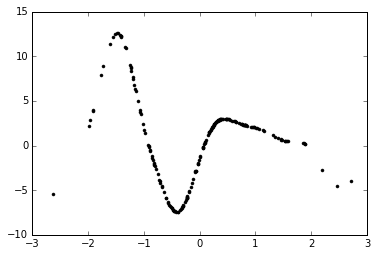

In [16]:
%matplotlib inline
plt.plot(X[:,0], latent.random(), 'k.');